In [1]:
!pip install --upgrade unsloth 

Looking in indexes: https://nexus.iisys.de/repository/ki-awz-pypi-group/simple, https://pypi.org/simple


In [2]:
!pip install transformers==4.55.4
!pip install --no-deps trl==0.22.2

Looking in indexes: https://nexus.iisys.de/repository/ki-awz-pypi-group/simple, https://pypi.org/simple
Looking in indexes: https://nexus.iisys.de/repository/ki-awz-pypi-group/simple, https://pypi.org/simple


In [3]:
!pip uninstall flash-attn -y
!pip install flash-attn==2.7.3 --no-cache-dir

Found existing installation: flash_attn 2.7.3
Uninstalling flash_attn-2.7.3:
  Successfully uninstalled flash_attn-2.7.3
Looking in indexes: https://nexus.iisys.de/repository/ki-awz-pypi-group/simple, https://pypi.org/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 68.8 MB/s  0:00:00
  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'flash-attn' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'flash-attn'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  Created wheel for flash-attn: filename=flash_attn-2.7.3-cp312-cp312-linux_x86_64.whl size=414494788 sha256=567bddcae6f7c133fd964bed9988926fe7aabaddb58bf62a744b2f782a7d4269
  Stored in director

In [4]:
pip install tensorboard

Looking in indexes: https://nexus.iisys.de/repository/ki-awz-pypi-group/simple, https://pypi.org/simple
Note: you may need to restart the kernel to use updated packages.


In [1]:
from unsloth import FastVisionModel # FastLanguageModel for LLMs
import torch

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Llama-3.2-11B-Vision-Instruct-bnb-4bit", # Llama 3.2 vision support
    "unsloth/Llama-3.2-11B-Vision-bnb-4bit",
    "unsloth/Llama-3.2-90B-Vision-Instruct-bnb-4bit", # Can fit in a 80GB card!
    "unsloth/Llama-3.2-90B-Vision-bnb-4bit",

    "unsloth/Pixtral-12B-2409-bnb-4bit",              # Pixtral fits in 16GB!
    "unsloth/Pixtral-12B-Base-2409-bnb-4bit",         # Pixtral base model

    "unsloth/Qwen2-VL-2B-Instruct-bnb-4bit",          # Qwen2 VL support
    "unsloth/Qwen2-VL-7B-Instruct-bnb-4bit",
    "unsloth/Qwen2-VL-72B-Instruct-bnb-4bit",

    "unsloth/llava-v1.6-mistral-7b-hf-bnb-4bit",      # Any Llava variant works!
    "unsloth/llava-1.5-7b-hf-bnb-4bit",
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Qwen2.5-VL-7B-Instruct-bnb-4bit",
    load_in_4bit = True, # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


[torchao|WARNING]Skipping import of cpp extensions due to incompatible torch version 2.8.0+cu128 for torchao version 0.14.1             Please see https://github.com/pytorch/ao/issues/2919 for more info


🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.10.11: Fast Qwen2_5_Vl patching. Transformers: 4.55.4.
   \\   /|    NVIDIA A100 80GB PCIe MIG 1g.10gb. Num GPUs = 1. Max memory: 9.5 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu128. CUDA: 8.0. CUDA Toolkit: 12.8. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.32.post2. FA2 = True]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [2]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = True, # False if not finetuning vision layers
    finetune_language_layers   = True, # False if not finetuning language layers
    finetune_attention_modules = True, # False if not finetuning attention layers
    finetune_mlp_modules       = True, # False if not finetuning MLP layers

    r = 32,           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 32,  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
    # target_modules = "all-linear", # Optional now! Can specify a list if needed
)

# Dataset

In [3]:
from datasets import load_dataset

dataset = load_dataset("Schnowflake/playing_cards_excercise", split="train")

In [4]:
print(dataset[0])

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=720x720 at 0x7F7EF690EB10>, 'qa': [{'question': 'what cards are in the image?', 'answer': '4 of club, 5 of spade, 8 of spade'}]}


In [5]:
instruction = "What cards are in the image?"

def convert_to_conversation(sample):
    #print(sample)
    conversation = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": instruction},
                {"type": "image", "image": sample["image"]},
            ],
        },
        {"role": "assistant", "content": [{"type": "text", "text": sample["qa"][0]["answer"]}]},
    ]
    return {"messages": conversation}
pass

In [6]:
import pandas as pd

converted_dataset=[]

dataframe = pd.DataFrame(dataset)

for index, row in dataframe.iterrows():
    converted_dataset.append(convert_to_conversation(row))

In [7]:
converted_dataset[0]

{'messages': [{'role': 'user',
   'content': [{'type': 'text', 'text': 'What cards are in the image?'},
    {'type': 'image',
     'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=720x720>}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': '4 of club, 5 of spade, 8 of spade'}]}]}

# Small Test

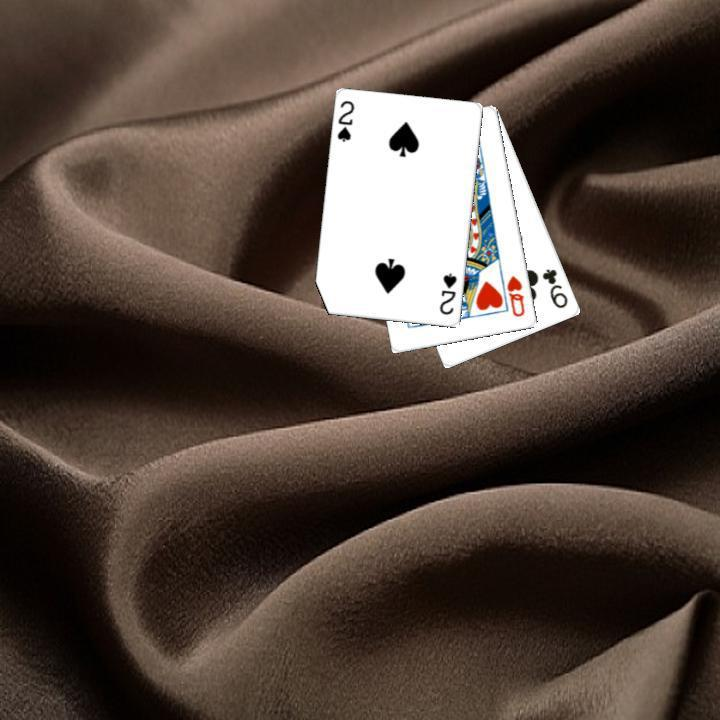

<|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>What cards are in the image?<|im_end|>
<|im_start|>assistant

2 of spade, 2 of heart, 6 of club<|im_end|>


In [17]:
FastVisionModel.for_inference(model)  # Enable for inference!

image = dataframe.iloc[1]["image"]
display(image)

instruction = "What cards are in the image?"

messages = [
    {
        "role": "user",
        "content": [{"type": "image"}, {"type": "text", "text": instruction}],
    }
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt=True)
#for certain models
#input_text = processor.decode(input_text)

#[2, 105, 2364, 107, 255999, 6974, 506, 4338, 32183, 23571, 532, 8974, 506, 29344, 106, 107, 105, 4368, 107]
print(str(input_text))

inputs = tokenizer(
    image,
    str(input_text),  
    add_special_tokens=False,
    return_tensors="pt",
).to("cuda")

from transformers import TextStreamer

text_streamer = TextStreamer(tokenizer, skip_prompt=True)
result = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                        use_cache=True, temperature = 1.0, top_p = 0.95, top_k = 64)

# Continue

In [8]:
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

FastVisionModel.for_training(model) # Enable for training!

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer), # Must use!
    train_dataset = converted_dataset,
    args = SFTConfig(
        per_device_train_batch_size = 1,
        gradient_accumulation_steps = 2,
        warmup_steps = 4,
        max_steps = 100,
        #num_train_epochs = 5, # Set this instead of max_steps for full training runs
        learning_rate = 1e-4,
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        logging_dir="./logs/my_run",
        report_to=["tensorboard"],

        # You MUST put the below items for vision finetuning:
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        max_length = 2048,
    ),
)

Unsloth: Model does not have a default image size - using 512


In [9]:
%load_ext tensorboard

In [10]:
%tensorboard --logdir ./logs

In [11]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,000 | Num Epochs = 1 | Total steps = 100
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 2
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 2 x 1) = 2
 "-____-"     Trainable parameters = 51,521,536 of 8,343,688,192 (0.62% trained)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELIS

Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,6.957800
2,6.883300
3,7.048200
4,6.799900
5,6.430000
6,5.494500
7,4.438900
8,3.907500
9,3.327100
10,2.586200


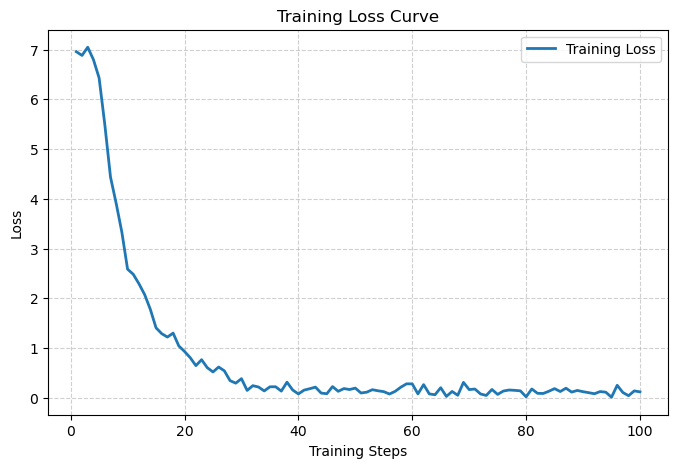

In [12]:
import matplotlib.pyplot as plt

# --- Visualization of loss over steps ---
train_logs = trainer.state.log_history

steps = [log["step"] for log in train_logs if "loss" in log]
losses = [log["loss"] for log in train_logs if "loss" in log]

plt.figure(figsize=(8, 5))
plt.plot(steps, losses, label="Training Loss", linewidth=2)
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()

# Lets test the results!

{'question': 'what cards are in the image?', 'answer': 'A of club, 2 of diamond, 9 of heart'}


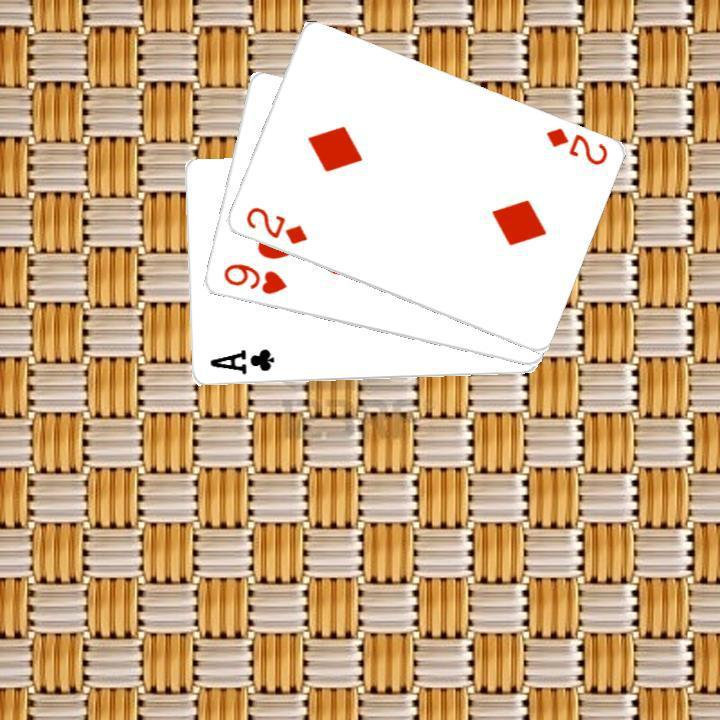

A of club, 2 of diamond, 6 of heart<|im_end|>


In [15]:
FastVisionModel.for_inference(model)  # Enable for inference!

image = dataframe.iloc[2]["image"]
print(dataframe.iloc[2]["qa"][0])
display(image)


instruction = "What cards are in the image?"

messages = [
    {
        "role": "user",
        "content": [{"type": "image"}, {"type": "text", "text": instruction}],
    }
]

input_text = tokenizer.apply_chat_template(messages, add_generation_prompt=True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens=False,
    return_tensors="pt",
).to("cuda")

from transformers import TextStreamer

text_streamer = TextStreamer(tokenizer, skip_prompt=True)
result = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                        use_cache=True, temperature = 1.0, top_p = 0.95, top_k = 64)

In [ ]:
model.save_pretrained("lora_model_cards")  # Local saving
processor.save_pretrained("lora_model_cards")
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving
# processor.push_to_hub("your_name/lora_model", token = "...") # Online saving

# To call the existing file

In [15]:
if False:
    from unsloth import FastVisionModel
    model, tokenizer = FastVisionModel.from_pretrained(
        model_name = "test_finetune", # YOUR MODEL YOU USED FOR TRAINING
        load_in_4bit = True, # Set to False for 16bit LoRA
    )
    FastVisionModel.for_inference(model) # Enable for inference!

instruction = "Name all the cards you can see!"

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

D _ { \mu } ^ { \alpha \beta } \bar { A } _ { \mu } ^ { \alpha \beta } = 0 ,
{ D } _ { \mu } ^ { \alpha \beta } \overline { A } _ { \mu } ^ { \alpha \beta } = 0 ,<end_of_turn>
